In [1]:
import os
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools

import sys
sys.path.insert(1, '../') #make parent folder visible
from transformer import Transformer, create_masks, nopeak_mask

import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
checkpoint_dir = "../checkpoints/"

In [3]:
smiles_strings = {
    "Arginine": "C(CC(C(=O)O)N)CN=C(N)N",
    "Histidine": "C1=C(NC=N1)CC(C(=O)O)N",
    "Isoleucine": "CCC(C)C(C(=O)O)N",
    "Leucine": "CC(C)CC(C(=O)O)N",
    "Lysine": "C(CCN)CC(C(=O)O)N",
    "Methionine": "CSCCC(C(=O)O)N",
    "Phenylalanine": "C1=CC=C(C=C1)CC(C(=O)O)N",
    "Threonine": "CC(C(C(=O)O)N)O",
    "Tryptophan": "C1=CC=C2C(=C1)C(=CN2)CC(C(=O)O)N",
    "Valine": "CC(C)C(C(=O)O)N",
    "Alanine": "CC(C(=O)O)N",
    "Asparagine": "C(C(C(=O)O)N)C(=O)N",
    "Aspartate": "C(C(C(=O)O)N)C(=O)O",
    "Glutamate": "C(CC(=O)O)C(C(=O)O)N",
    "Glycine": "C(C(=O)O)N",
    "Serine": "C(C(C(=O)O)N)O",
    "Tyrosine": "C1=CC(=CC=C1CC(C(=O)O)N)O",
    "Cysteine": "C(C(C(=O)O)N)S",
    "Glutamine": "C(CC(=O)N)C(C(=O)O)N",
    #"Hydroxyproline": "C1C(CNC1C(=O)O)O",
    "Proline": "C1CC(NC1)C(=O)O",
    #"Taurine": "C(CS(=O)(=O)O)N",
}

acids = [
    "Arg",
    "His",
    "Ile",
    "Leu",
    "Lys",
    "Met",
    "Phe",
    "Thr",
    "Trp",
    "Val",
    "Ala",
    "Asn",
    "Asp",
    "Glu",
    "Gly",
    "Ser",
    "Tyr",
    "Cys",
    "Gln",
    "Pro"
]

In [4]:
MAX_LEN = 256
MODEL_DIM = 512
N_LAYERS = 6

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
TRANSFORMER_DEVICE = DEVICE #torch.device("cpu")

PRINTABLE_ASCII_CHARS = 95

_extra_chars = ["seq_start", "seq_end", "pad"]
EXTRA_CHARS = {key: chr(PRINTABLE_ASCII_CHARS + i) for i, key in enumerate(_extra_chars)}
ALPHABET_SIZE = PRINTABLE_ASCII_CHARS + len(EXTRA_CHARS)

cuda


In [5]:
def find_ckpts(*args, **kwargs):
    ckpts = os.listdir(checkpoint_dir)
    str_args = [str(x) for x in itertools.chain(args, kwargs.values())]
    return [checkpoint_dir + ckpt for ckpt in ckpts if all([arg in ckpt.replace(".", "_").split("_") for arg in str_args])]

def encode_char(c):
    return ord(c) - 32

def decode_char(n):
    return chr(n + 32)

def encode_smiles(string, start_char=EXTRA_CHARS['seq_start']):
    return torch.tensor([ord(start_char)] + [encode_char(c) for c in string])

def pad_tensors(tensors, pad_char=chr(0), max_len=None):
    if not max_len:
        max_len = max([t.shape[0] for t in tensors]) + 1
        
    padded_tensors = torch.full((len(tensors), max_len), ord(pad_char), dtype=torch.long)
    for i, tensor in enumerate(tensors):
        padded_tensors[i, 0:tensor.shape[0]] = tensor
        
    return padded_tensors

In [6]:
found = find_ckpts()
print(found)
load_path = found[0] if len(found) > 0 else ""

['../checkpoints/pretrained.ckpt']


In [7]:
model = Transformer(ALPHABET_SIZE, MODEL_DIM, N_LAYERS)
model = nn.DataParallel(model)
model = model.to(TRANSFORMER_DEVICE)

In [8]:
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.eval()

In [9]:
vectors = []
with torch.no_grad():
    for name, smiles in smiles_strings.items():
        encoded = encode_smiles(smiles, start_char=EXTRA_CHARS['seq_start']).unsqueeze(0).to(TRANSFORMER_DEVICE)
        encoded = encoded[:,:MAX_LEN]
        mask = create_masks(encoded)
        embedding = model.module.encoder(encoded, mask)[0].cpu().numpy()
        flattened = embedding.mean(axis=0)
        print(name, smiles, flattened.shape)
        vectors.append(flattened)
vectors = np.stack(vectors)
vectors.shape

Arginine C(CC(C(=O)O)N)CN=C(N)N (512,)
Histidine C1=C(NC=N1)CC(C(=O)O)N (512,)
Isoleucine CCC(C)C(C(=O)O)N (512,)
Leucine CC(C)CC(C(=O)O)N (512,)
Lysine C(CCN)CC(C(=O)O)N (512,)
Methionine CSCCC(C(=O)O)N (512,)
Phenylalanine C1=CC=C(C=C1)CC(C(=O)O)N (512,)
Threonine CC(C(C(=O)O)N)O (512,)
Tryptophan C1=CC=C2C(=C1)C(=CN2)CC(C(=O)O)N (512,)
Valine CC(C)C(C(=O)O)N (512,)
Alanine CC(C(=O)O)N (512,)
Asparagine C(C(C(=O)O)N)C(=O)N (512,)
Aspartate C(C(C(=O)O)N)C(=O)O (512,)
Glutamate C(CC(=O)O)C(C(=O)O)N (512,)
Glycine C(C(=O)O)N (512,)
Serine C(C(C(=O)O)N)O (512,)
Tyrosine C1=CC(=CC=C1CC(C(=O)O)N)O (512,)
Cysteine C(C(C(=O)O)N)S (512,)
Glutamine C(CC(=O)N)C(C(=O)O)N (512,)
Proline C1CC(NC1)C(=O)O (512,)


(20, 512)

In [10]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)
reduced.shape

(20, 2)

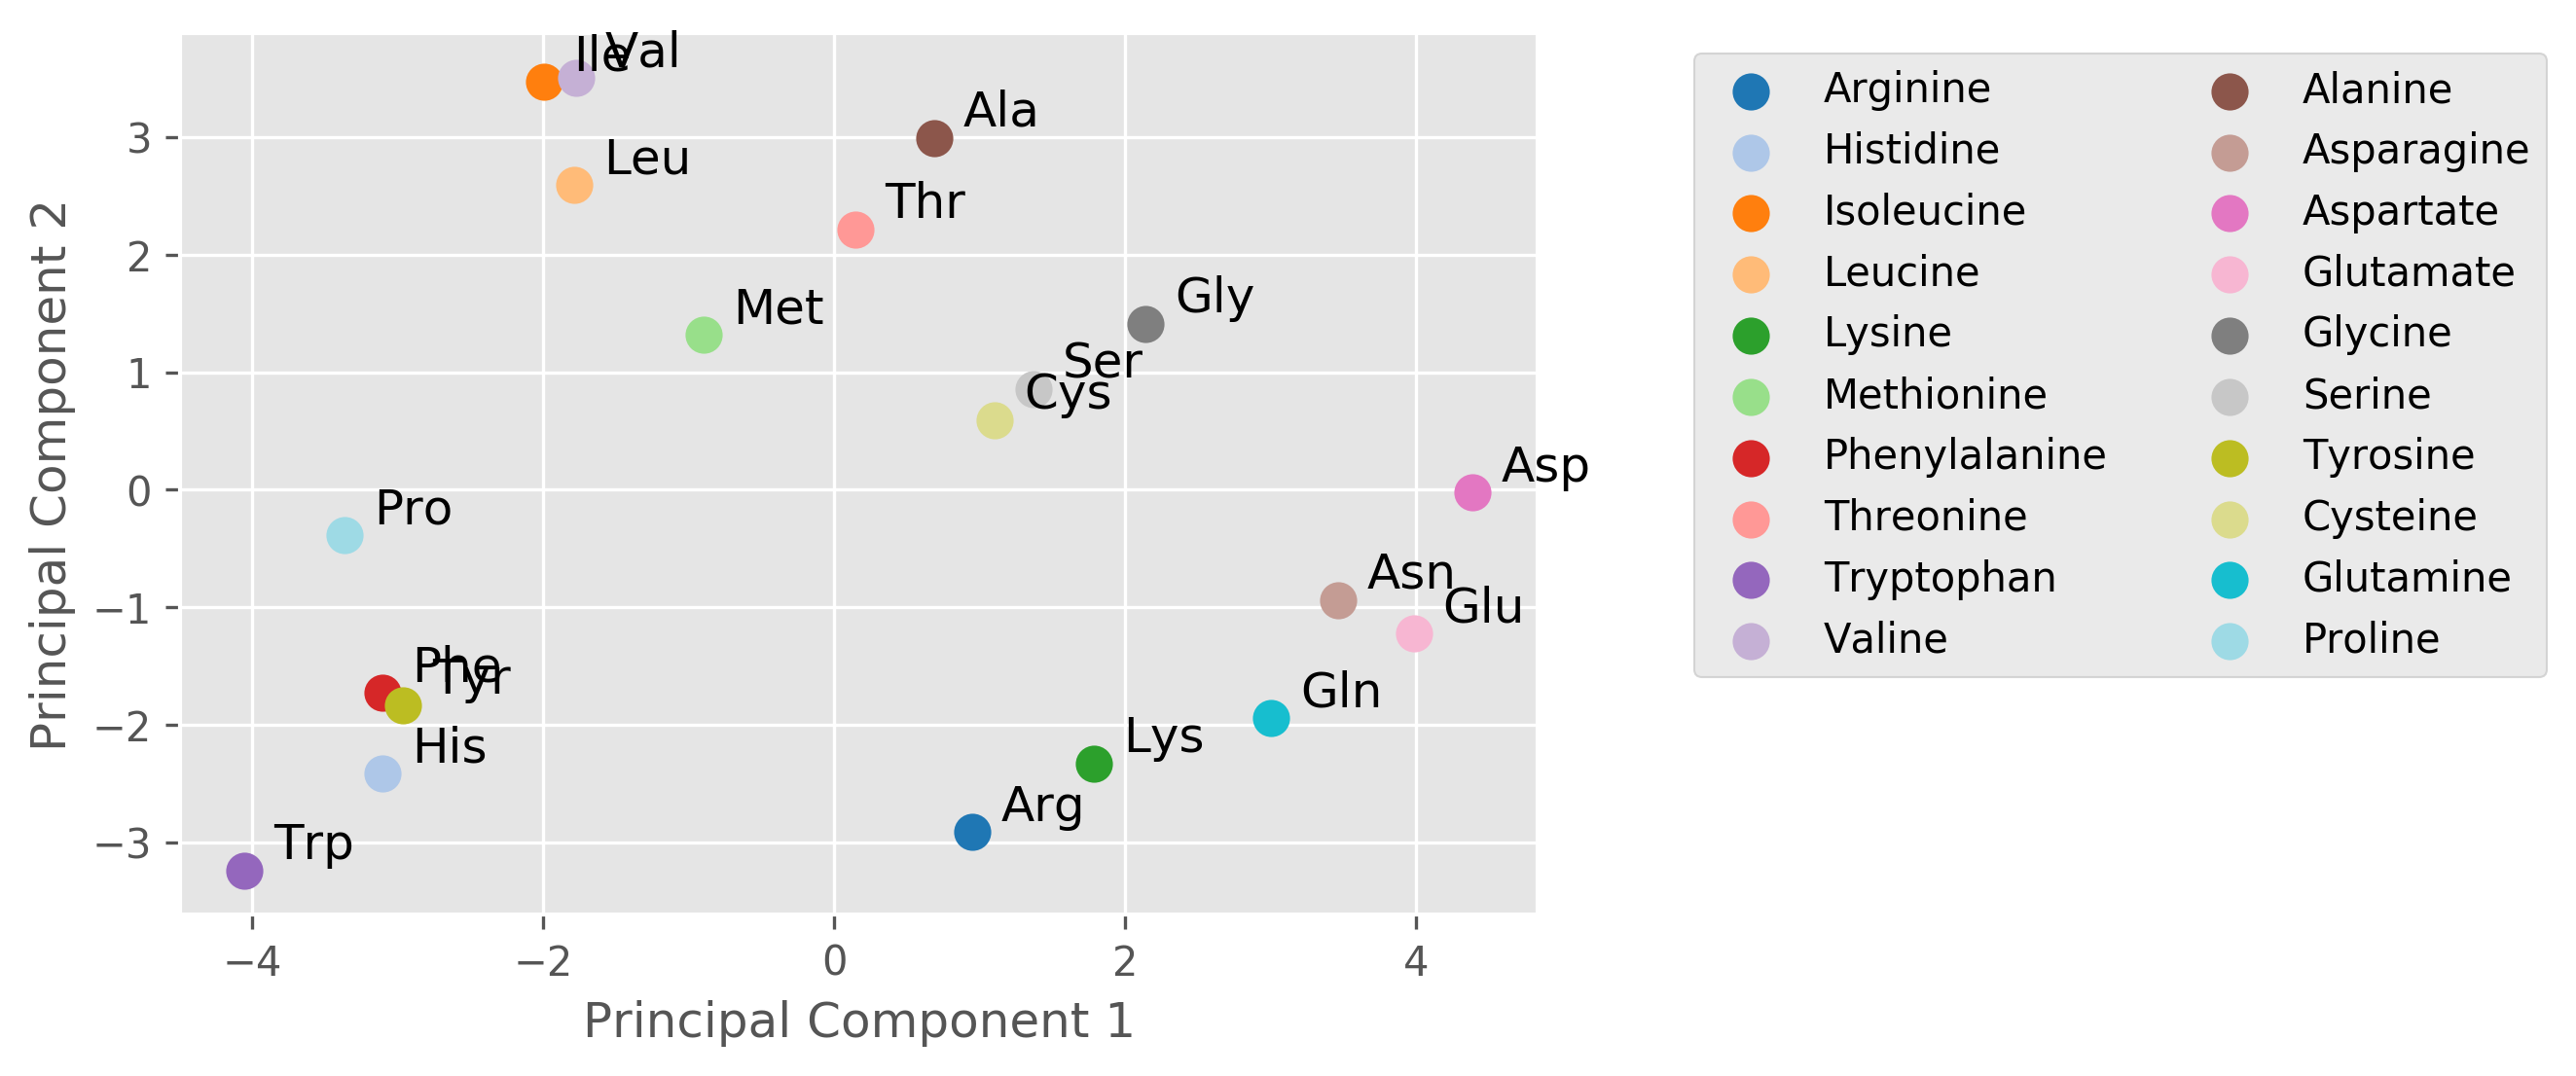

In [11]:
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.dpi'] = 300

cmap = matplotlib.cm.get_cmap('tab20')
for i, acid_name in enumerate(acids):
    x, y = reduced[i, 0], reduced[i, 1]
    plt.scatter(x, y, c=[cmap(i/len(acids))], s=75, label=list(smiles_strings.keys())[i])
    plt.text(x+.2, y+.1, acid_name, fontsize=12)
plt.legend(loc="upper left", bbox_to_anchor=(1.1,1), ncol=2)
#plt.gca().set_aspect('equal', adjustable='box')
#plt.tight_layout()
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()